# Dependencies and notebook settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.stats import diagnostic
import statsmodels.api as sm
from tqdm import tqdm
from IPython.core.display import display, HTML
from var_test import *
from arch import arch_model

display(HTML("<style>.container { width:90% !important; }</style>"))
plt.style.use("ggplot")
mpl.rcParams["figure.dpi"] = 100

# Dependencies and notebook settings

In [2]:
df = pd.read_csv(
    "../dataset/spx.csv",
    parse_dates=["Date"],
    names=["Date", "Open", "High", "Low", "Close", "Volume"],
    header=0,
    index_col="Date")
df = df[df.index < "2020-10-01"]
df["rr"] = (np.log(df.Close) - np.log(df.Close.shift(1))) * 100
df = df.tail(252 * 4)
df = df[["rr"]]
df.dropna(inplace=True)

# GARCH modeling

## Choice of mean (lag) and variance (p,o,q) models using BIC

In [3]:
y_train = df["rr"].head(252*3)
garch_comparison = list()

#below grid function is nonoptimal (some combinations are completely redundant, but due to low computational requirements I didnt adjust it)
for i in tqdm(["Constant", "Zero", "AR"]):
    for j in ["GARCH", "ARCH", "EGARCH", "HARCH"]:
        for k in ["normal", "t", "skewt", "ged"]:
            for l in [1, 2, 3, 4]:
                for m in [1, 2, 3, 4]:
                    for o in [0, 1, 2]:
                        try:
                            am = arch_model(y_train, vol=j, p=l, o=0, q=m, mean=i, dist=k, lags=o)
                            res = am.fit(disp="off")
                            garch_comparison.append([i, j, k, l, m, o, res.bic, res.loglikelihood])
                        except:
                            pass
                    
garch_comparison = pd.DataFrame(garch_comparison, columns=["mean_model", "variance_model", "distribution", "p", "q", "lags", "bic", "log_likelihood"])                    
garch_comparison.sort_values(["bic","p","q","lags","mean_model"], ascending=[True, True, True, True, False], inplace=True)
garch_comparison.drop_duplicates(subset='bic', keep="first", inplace=True)
garch_comparison.sort_values(["bic","p","q","lags","mean_model"], ascending=[True, True, True, True, False], inplace=True)

 33%|████████████████████████████                                                        | 1/3 [01:03<02:06, 63.49s/it]C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\distribution.py:1053: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu
C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\distribution.py:1053: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu
C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\distribution.py:1053: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:15<00:00, 65.27s/it]


Models sorted by BIC (ascending)

In [4]:
garch_comparison.head(20)

,mean_model,variance_model,distribution,p,q,lags,bic,log_likelihood
1681,AR,GARCH,ged,1,1,1,1491.808580,-726.024137
144,Constant,GARCH,ged,1,1,0,1492.445555,-729.652674
1585,AR,GARCH,t,1,1,1,1493.431739,-726.835716
48,Constant,GARCH,t,1,1,0,1493.704757,-730.282275
1682,AR,GARCH,ged,1,1,2,1495.587772,-724.605013
2065,AR,EGARCH,ged,1,1,1,1497.318220,-728.778957
1586,AR,GARCH,t,1,1,2,1497.318359,-725.470306
1693,AR,GARCH,ged,2,1,1,1497.531589,-725.572282
528,Constant,EGARCH,ged,1,1,0,1497.720737,-732.290265
1969,AR,EGARCH,t,1,1,1,1498.221723,-729.230708


Additional BIC statistics for fitted models grouped by: variance_model, mean_model and distribution

In [5]:
display(garch_comparison.groupby("variance_model")["bic"].agg(["mean","median"]).sort_values("mean"))
display(garch_comparison.groupby("mean_model")["bic"].agg(["mean","median"]).sort_values("mean"))
display(garch_comparison.groupby("distribution")["bic"].agg(["mean","median"]).sort_values("mean"))

,mean,median
variance_model,,
GARCH,1534.759616,1520.712516
EGARCH,1541.356201,1525.211013
ARCH,1582.715333,1559.903044
HARCH,1583.652327,1560.713109


,mean,median
mean_model,,
Constant,1544.069847,1525.199460
AR,1545.689798,1526.754428
Zero,1552.882928,1531.492345


,mean,median
distribution,,
ged,1522.574294,1519.378277
t,1525.173759,1521.609261
skewt,1528.459983,1523.559371
normal,1612.124335,1599.274911


Final choice of GARCH functional forms per each distribution

In [6]:
first_group = garch_comparison.loc[garch_comparison.groupby('distribution').bic.idxmin()]
second_group = garch_comparison.loc[garch_comparison[garch_comparison.index.isin(first_group.index.tolist()) == False].groupby('distribution').bic.idxmin()]

display(first_group)
display(second_group)

,mean_model,variance_model,distribution,p,q,lags,bic,log_likelihood
1681,AR,GARCH,ged,1,1,1,1491.808580,-726.024137
1537,AR,GARCH,normal,1,1,1,1573.891194,-770.378803
1633,AR,GARCH,skewt,1,1,1,1498.255428,-725.934202
1585,AR,GARCH,t,1,1,1,1493.431739,-726.835716


,mean_model,variance_model,distribution,p,q,lags,bic,log_likelihood
144,Constant,GARCH,ged,1,1,0,1492.445555,-729.652674
0,Constant,GARCH,normal,1,1,0,1575.809208,-774.648521
96,Constant,GARCH,skewt,1,1,0,1498.814551,-729.523151
48,Constant,GARCH,t,1,1,0,1493.704757,-730.282275


## Models estimation and VaR calculation

In [83]:
def garch_estimator(y, dist):
    if dist != "qml":
        am = arch_model(y, vol="GARCH", p=1, o=0, q=1, dist=dist, mean="AR", lags=1)
    else:
        am = arch_model(y, vol="GARCH", p=1, o=0, q=1, dist="normal", mean="AR", lags=1)

    res = am.fit(disp="off")
    forecasts = res.forecast(horizon=1)
    cond_mean = forecasts.mean.iloc[-1, 0]
    cond_var = forecasts.variance.iloc[-1, 0]

    if dist in ["t", "ged"]:
        q = am.distribution.ppf([0.01, 0.025], res.params[-1:])
    elif dist == "skewt":
        q = am.distribution.ppf([0.01, 0.025], res.params[-2:])
    elif dist == "normal":
        q = am.distribution.ppf([0.01, 0.025])
    elif dist == "qml":
        q = np.nanpercentile(y/cond_var**0.5, [0.01, 0.025])
    else:
        raise Exception("Unknown dist")

    VaR = cond_mean + np.sqrt(cond_var) * q
    return VaR

In [84]:
Ar1Garch11Ged_1 = list()
Ar1Garch11Ged_25 = list()
Ar1Garch11Normal_1 = list()
Ar1Garch11Normal_25 = list()
Ar1Garch11Skewt_1 = list()
Ar1Garch11Skewt_25 = list()
Ar1Garch11T_1 = list()
Ar1Garch11T_25 = list()
Ar1Garch11QML_1 = list()
Ar1Garch11QML_25 = list()

for i in tqdm(range(0, 252)):
    y_train = df["rr"].iloc[i : i + 252 * 3].values
    
    tmp, tmp1 = garch_estimator(y_train, "ged")
    Ar1Garch11Ged_1.append(tmp)
    Ar1Garch11Ged_25.append(tmp1)
    
    tmp, tmp1 = garch_estimator(y_train, "normal")
    Ar1Garch11Normal_1.append(tmp)
    Ar1Garch11Normal_25.append(tmp1)
    
    tmp, tmp1 = garch_estimator(y_train, "skewt")
    Ar1Garch11Skewt_1.append(tmp)
    Ar1Garch11Skewt_25.append(tmp1)
    
    tmp, tmp1 = garch_estimator(y_train, "t")
    Ar1Garch11T_1.append(tmp)
    Ar1Garch11T_25.append(tmp1)
    
    tmp, tmp1 = garch_estimator(y_train, "qml")
    Ar1Garch11QML_1.append(tmp)
    Ar1Garch11QML_25.append(tmp1)

100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [01:00<00:00,  4.14it/s]


In [85]:
results_dict = {
    "rr":df.tail(252).rr.values,
    "Ar1Garch11Ged_1": Ar1Garch11Ged_1,
    "Ar1Garch11Ged_25": Ar1Garch11Ged_25,
    "Ar1Garch11Normal_1": Ar1Garch11Normal_1,
    "Ar1Garch11Normal_25": Ar1Garch11Normal_25,
    "Ar1Garch11Skewt_1": Ar1Garch11Skewt_1,
    "Ar1Garch11Skewt_25": Ar1Garch11Skewt_25,
    "Ar1Garch11T_1": Ar1Garch11T_1,
    "Ar1Garch11T_25": Ar1Garch11T_25,
    "Ar1Garch11QML_1": Ar1Garch11QML_1,
    "Ar1Garch11QML_25": Ar1Garch11QML_25,
}

results = pd.DataFrame(results_dict, index = df.tail(252).index)

In [86]:
results.head()

,rr,Ar1Garch11Ged_1,Ar1Garch11Ged_25,Ar1Garch11Normal_1,Ar1Garch11Normal_25,Ar1Garch11Skewt_1,Ar1Garch11Skewt_25,Ar1Garch11T_1,Ar1Garch11T_25,Ar1Garch11QML_1,Ar1Garch11QML_25
Date,,,,,,,,,,,
2019-10-02,-1.806544,-1.884119,-1.430981,-1.623028,-1.334452,-1.882266,-1.362204,-1.826730,-1.321805,-3.947923,-3.907340
2019-10-03,0.794038,-2.724346,-2.074225,-2.472762,-2.046286,-2.663389,-1.931371,-2.584880,-1.876129,-3.922066,-3.881483
2019-10-04,1.411674,-2.689739,-2.080009,-2.416012,-2.029375,-2.680955,-1.981482,-2.586738,-1.911264,-4.118269,-4.077686
2019-10-07,-0.448836,-2.946258,-2.286098,-2.630720,-2.217411,-2.949186,-2.188995,-2.834534,-2.102631,-4.163622,-4.123039
2019-10-08,-1.568317,-2.608904,-2.001359,-2.226336,-1.854690,-2.648439,-1.938686,-2.556825,-1.871332,-4.023781,-3.983198


In [87]:
results.tail()

,rr,Ar1Garch11Ged_1,Ar1Garch11Ged_25,Ar1Garch11Normal_1,Ar1Garch11Normal_25,Ar1Garch11Skewt_1,Ar1Garch11Skewt_25,Ar1Garch11T_1,Ar1Garch11T_25,Ar1Garch11QML_1,Ar1Garch11QML_25
Date,,,,,,,,,,,
2020-09-24,0.298295,-3.847559,-2.979134,-3.441379,-2.840513,-4.107808,-3.054391,-3.792007,-2.839341,-12.182216,-11.868431
2020-09-25,1.585048,-3.604995,-2.835940,-3.186982,-2.667845,-3.948618,-2.996596,-3.584929,-2.727310,-12.446754,-12.132969
2020-09-28,1.598215,-3.787358,-3.005561,-3.378656,-2.849428,-4.164549,-3.195937,-3.743849,-2.876022,-12.574354,-12.260569
2020-09-29,-0.482424,-3.919770,-3.110757,-3.512951,-2.962315,-4.319315,-3.314505,-3.848658,-2.957363,-12.572722,-12.258937
2020-09-30,0.821983,-3.321219,-2.598109,-2.887317,-2.403356,-3.721225,-2.809914,-3.321902,-2.512761,-12.370439,-12.056654


# Results backtesting

In [88]:
models = set([i.split("_")[0] for i in results_dict.keys()])
models.remove("rr")
alphas = ["1", "25"]

## Visualization -  realization of rates of return vs VaR forecasts

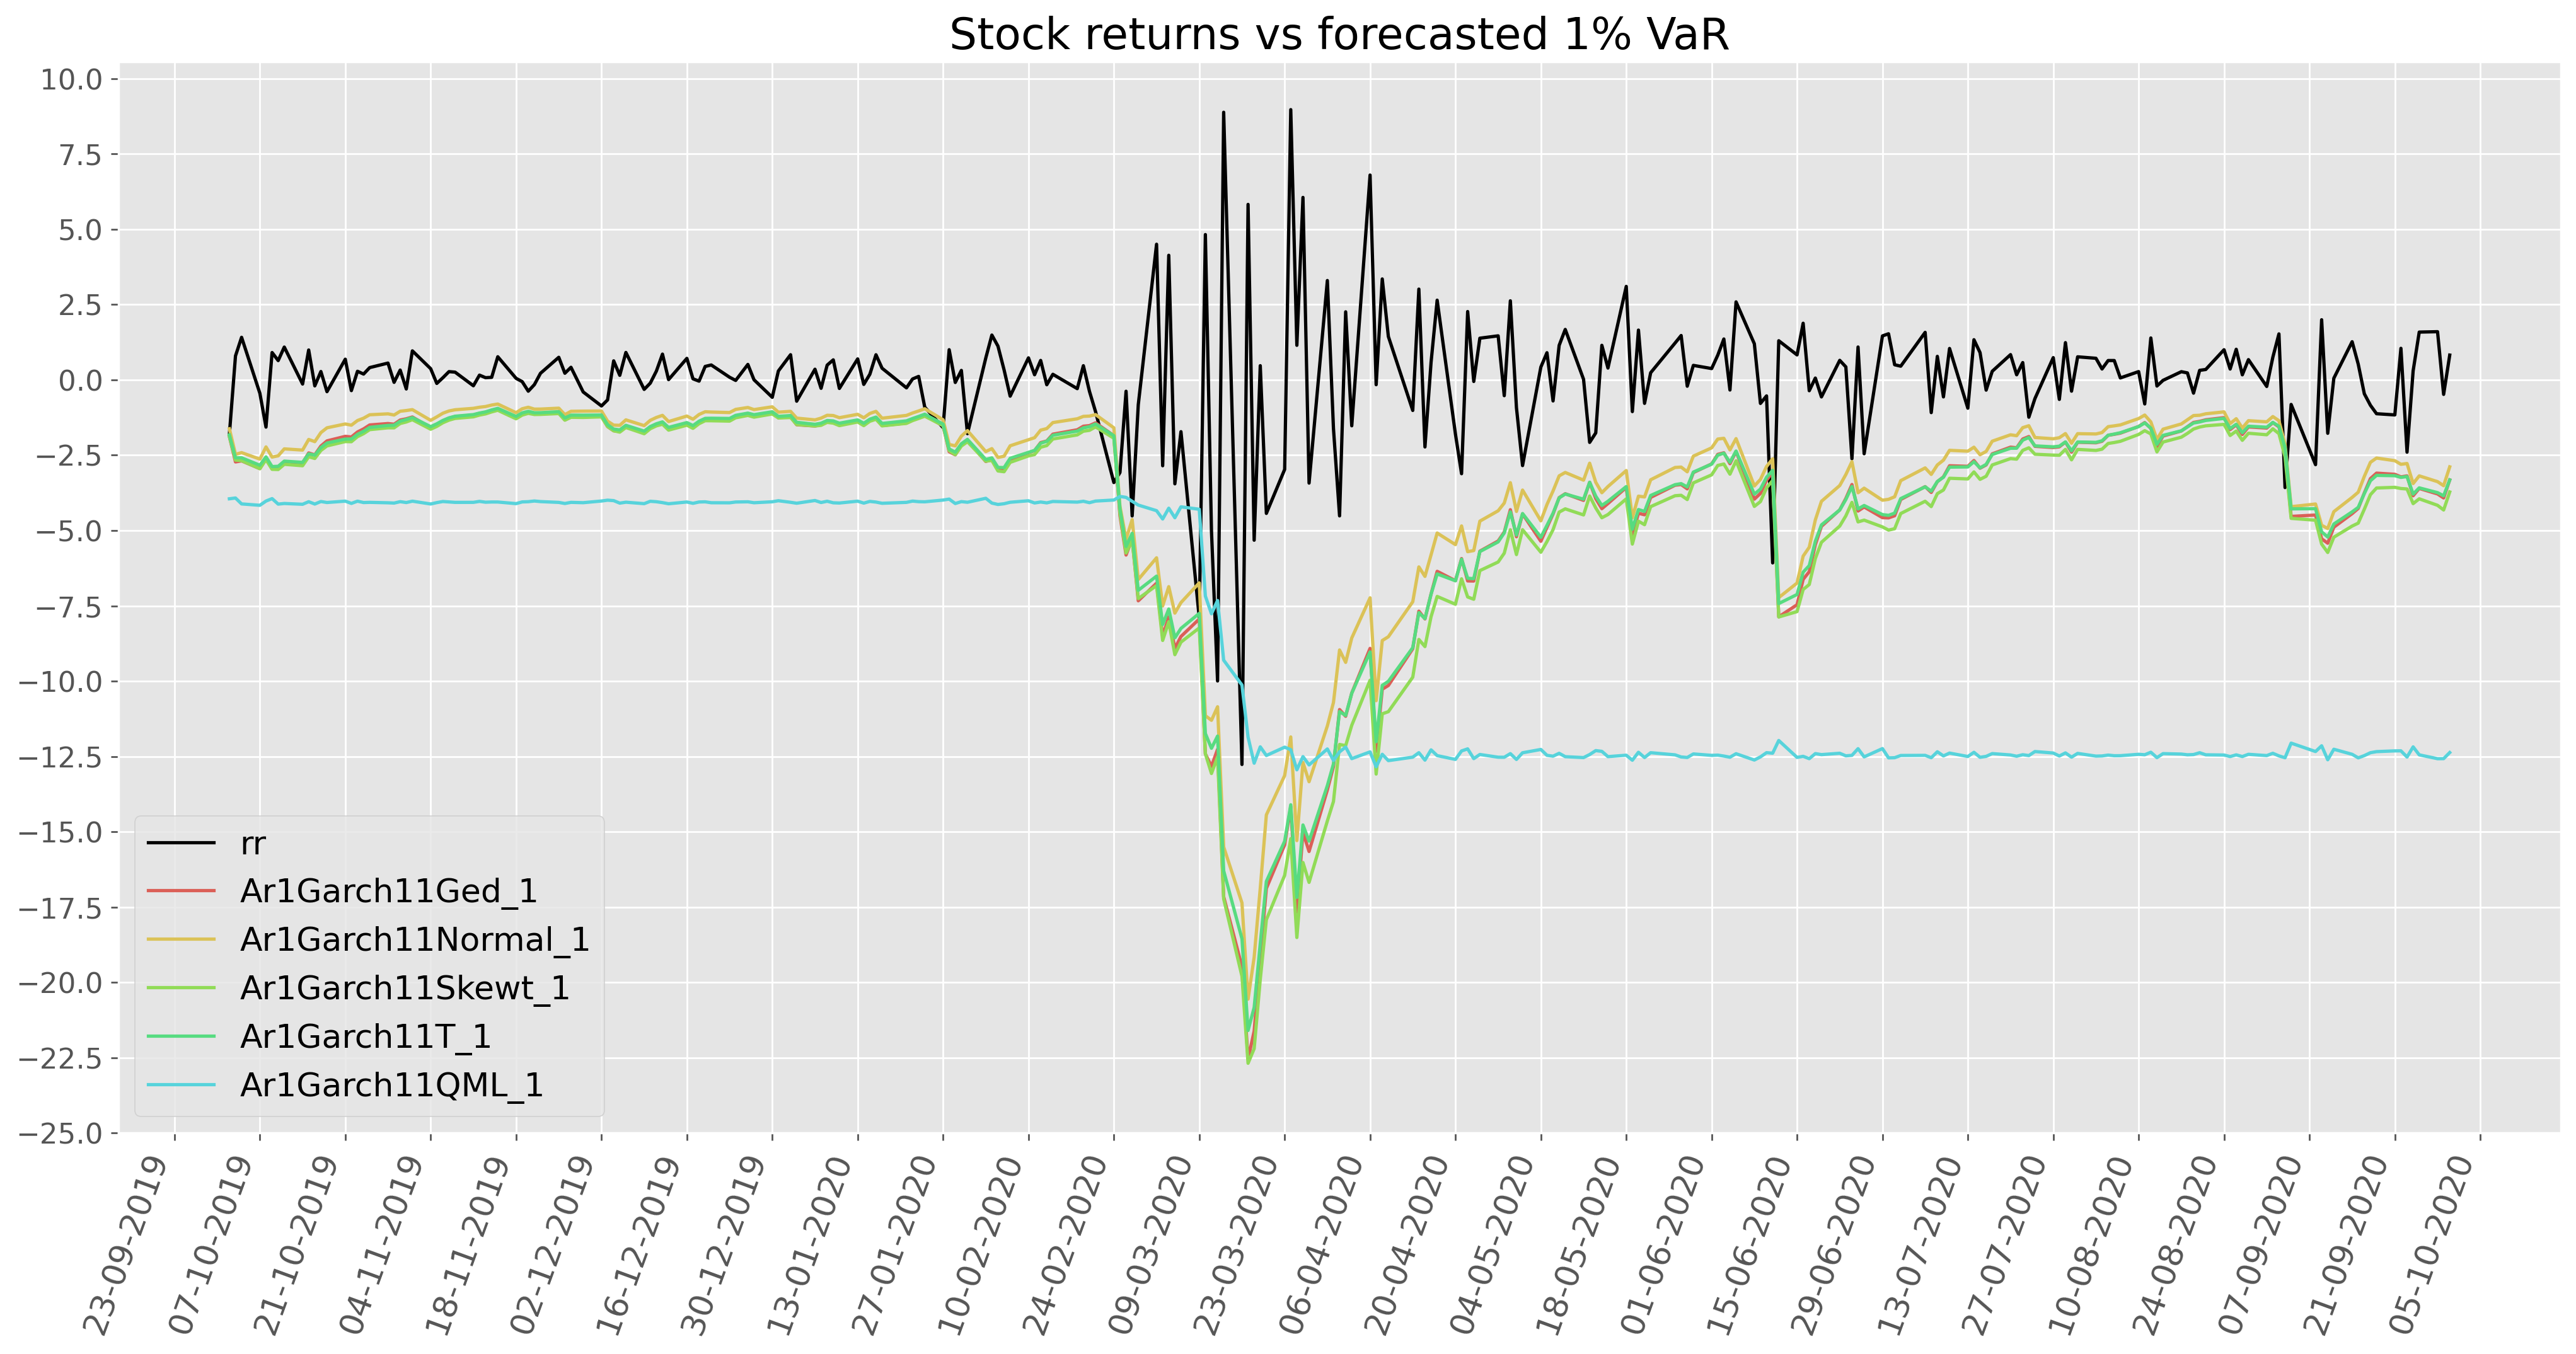

In [89]:
viz1_df = results.loc[:,(results.columns.str.endswith(("1","rr")))]

mpl.rcParams["figure.dpi"] = 250
plt.rcParams["figure.figsize"] = (20, 10)
cols = list(sns.color_palette("hls", 8))
cols.insert(0,(0,0,0))
ax = viz1_df.plot(color = cols)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()
plt.title("Stock returns vs forecasted 1% VaR", fontsize=20)
plt.xlabel("")
plt.legend(fontsize=15)
plt.xticks(rotation=70, fontsize=15)
plt.yticks(np.arange(-25,12.5, 2.5),fontsize=13)
plt.show()

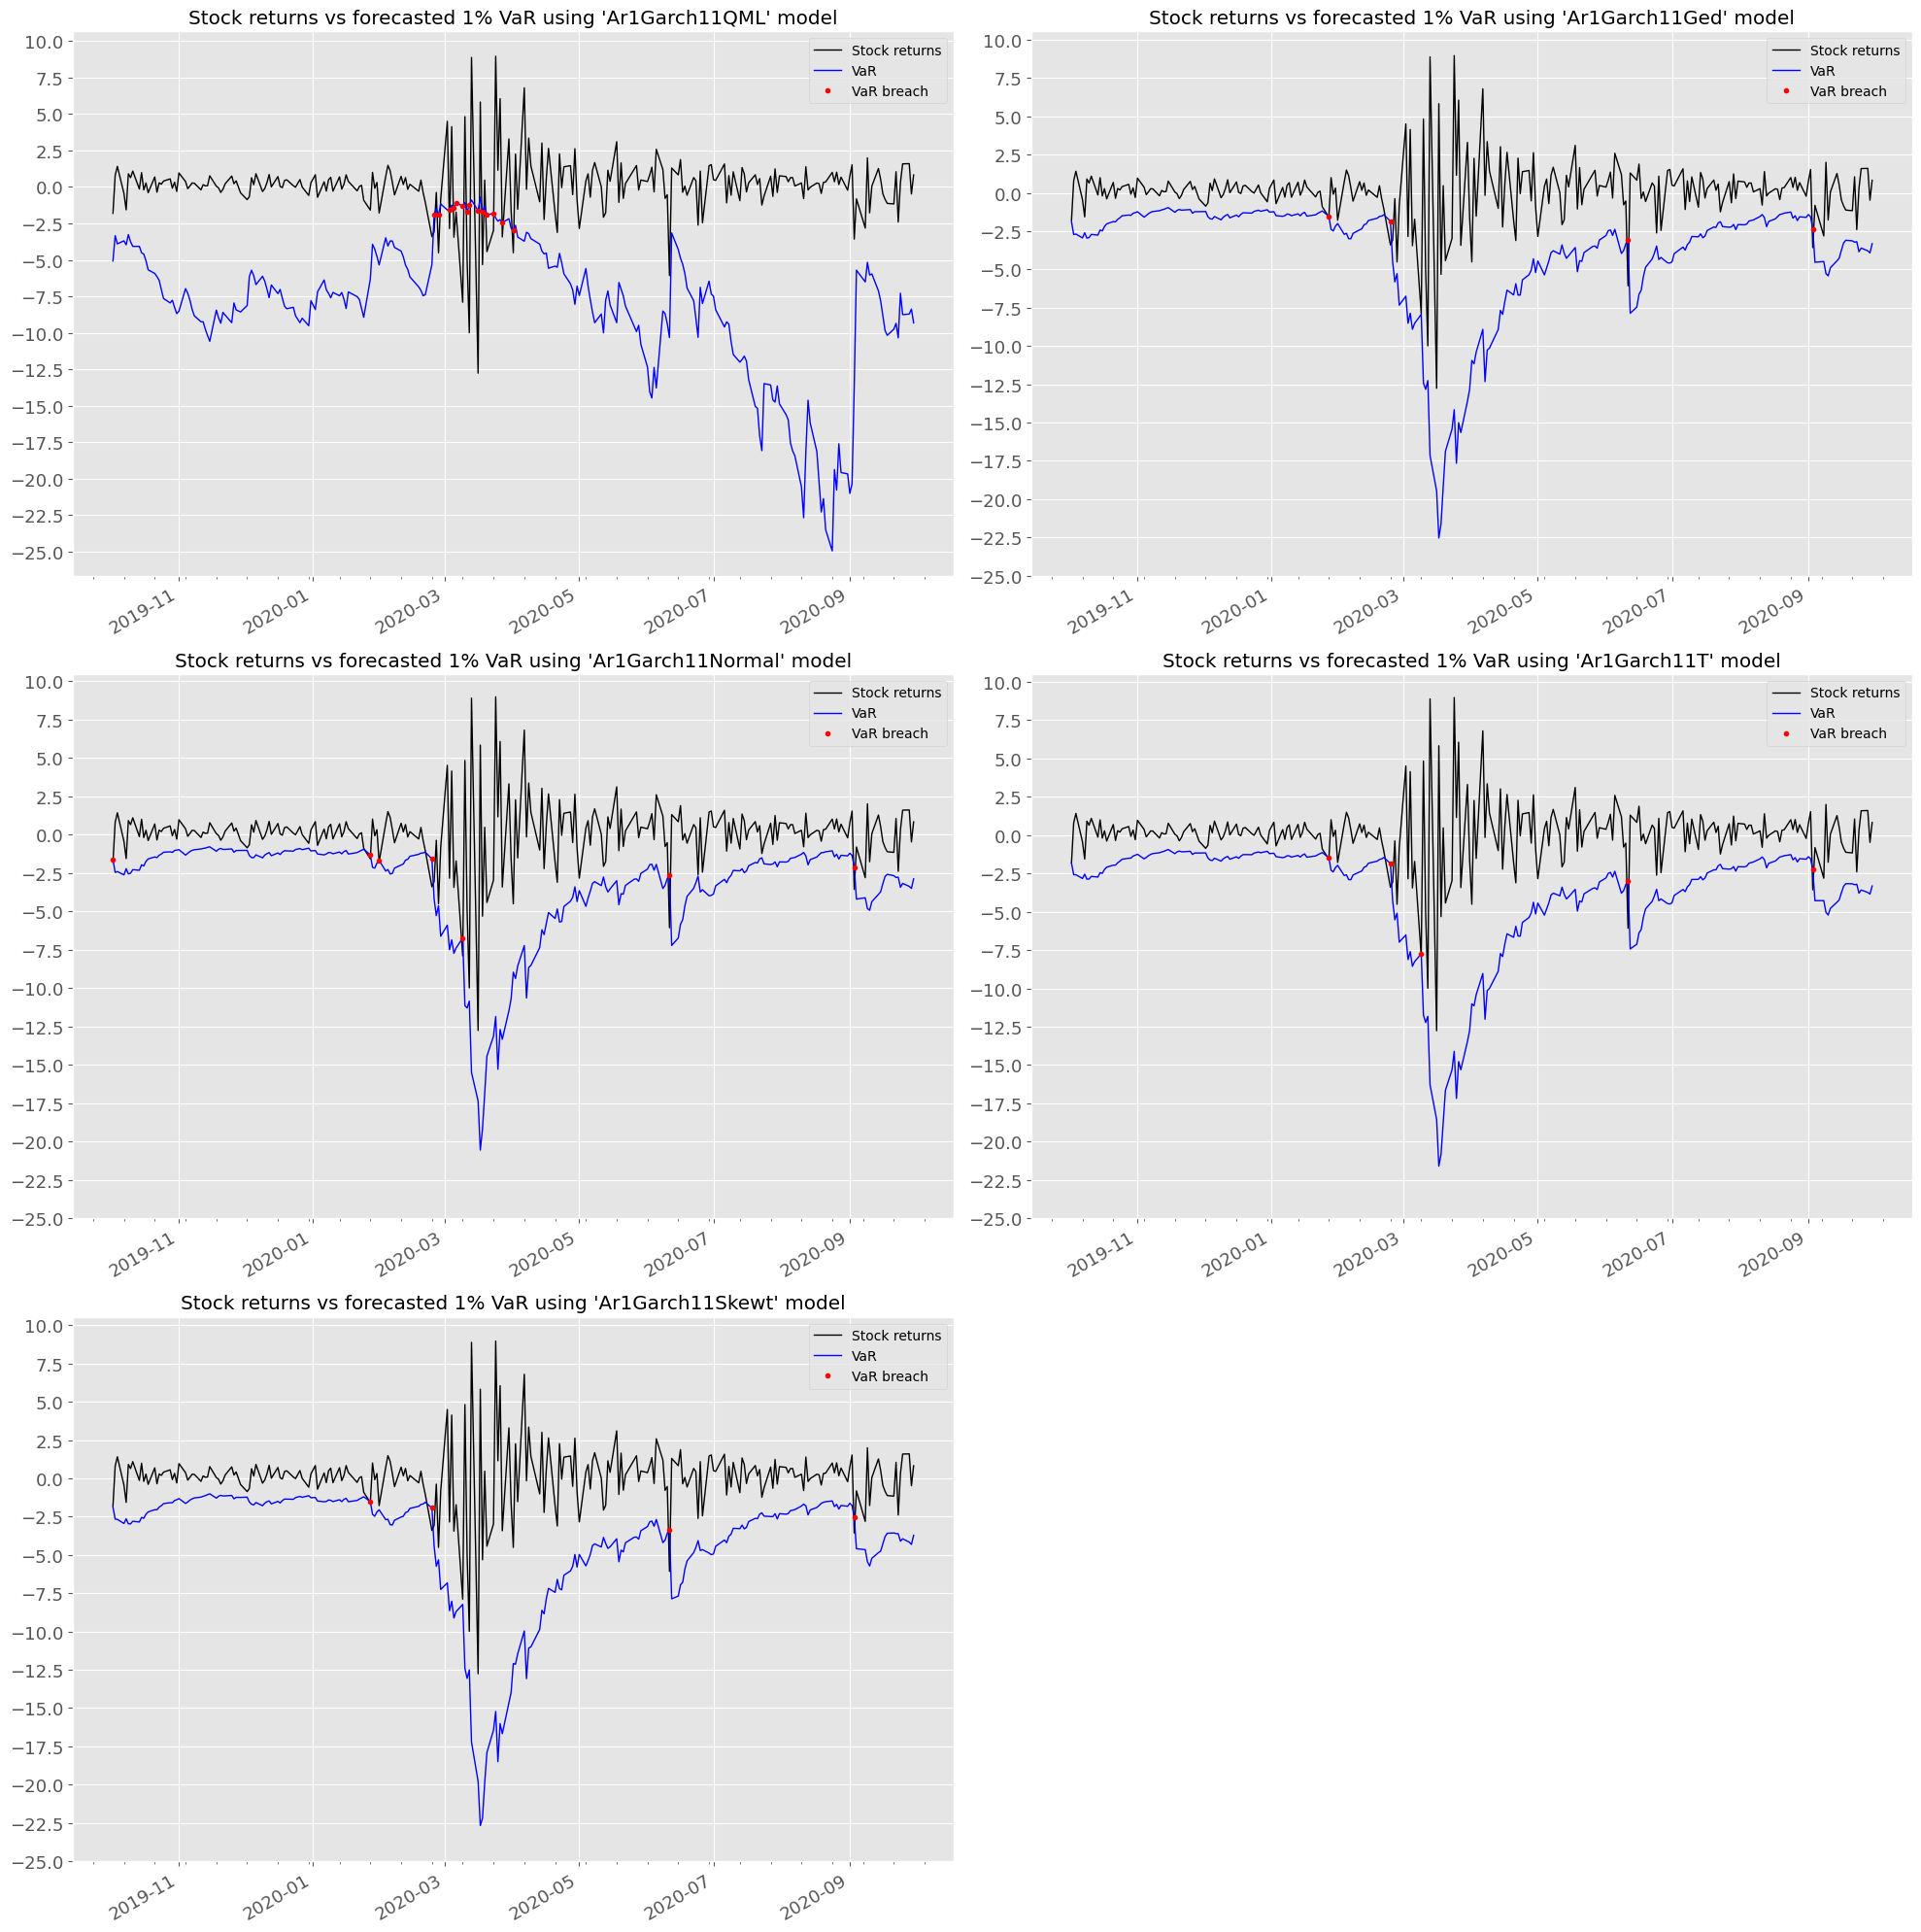

In [82]:
models_list = list(models)

mpl.rcParams["figure.dpi"] = 100
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
for i, ax in zip(range(0,5), axes.flat):
    name = models_list[i] + "_1"
    viz1_df["rr"].plot(color='black', linewidth=1, ax=ax)
    viz1_df[name].plot(color='blue', linewidth=1, ax=ax)
    ax.plot(viz1_df[name][viz1_df["rr"] < viz1_df[name]], color='red', linewidth=0, marker='.')
    ax.set_xlabel("")
    name_plot = "Stock returns vs forecasted 1% VaR using '" + name.split("_")[0] + "' model"
    ax.set_title(name_plot)
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.set_yticks(np.arange(-25,12.5, 2.5))
    ax.legend(["Stock returns","VaR","VaR breach"])
    
fig.tight_layout()
fig.delaxes(axes[2][1])
plt.show()

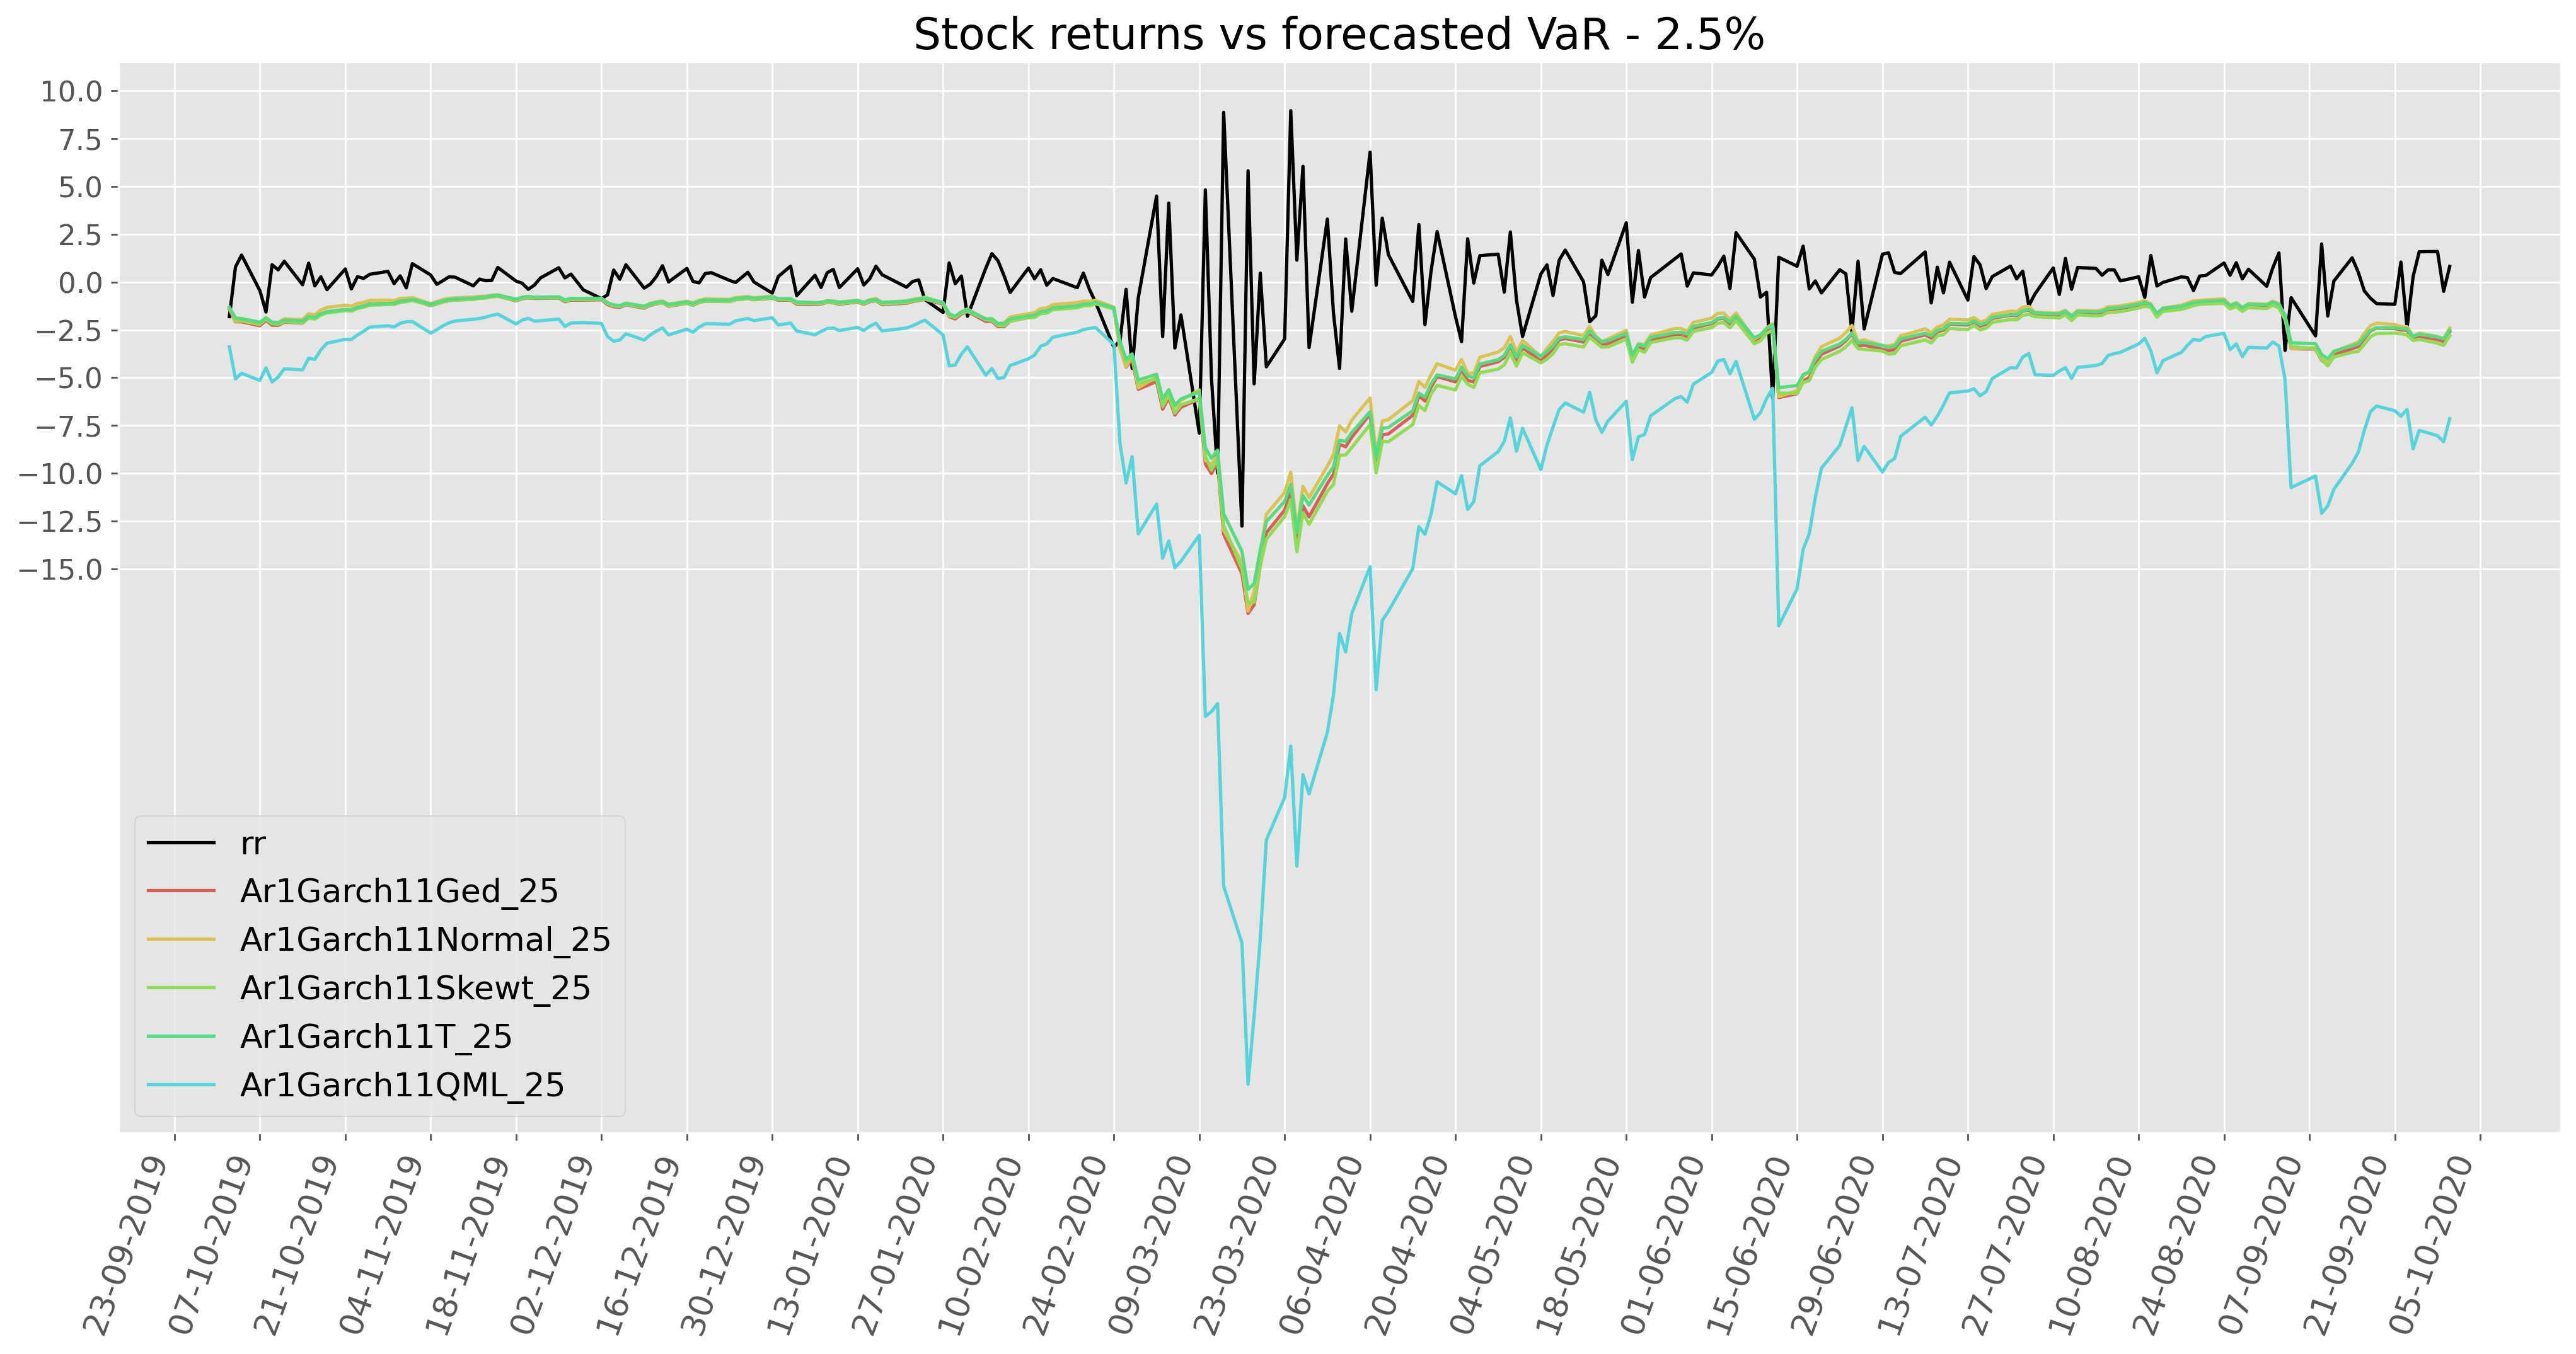

In [51]:
viz25_df = results.loc[:,(results.columns.str.endswith(("25","rr")))]

mpl.rcParams["figure.dpi"] = 250
plt.rcParams["figure.figsize"] = (20, 10)
cols = list(sns.color_palette("hls", 8))
cols.insert(0,(0,0,0))
ax = viz25_df.plot(color = cols)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()
plt.title("Stock returns vs forecasted VaR - 2.5%", fontsize=20)
plt.xlabel("")
plt.legend(fontsize=15)
plt.xticks(rotation=70, fontsize=15)
plt.yticks(np.arange(-15,12.5, 2.5),fontsize=13)
plt.show()

IndexError: list index out of range

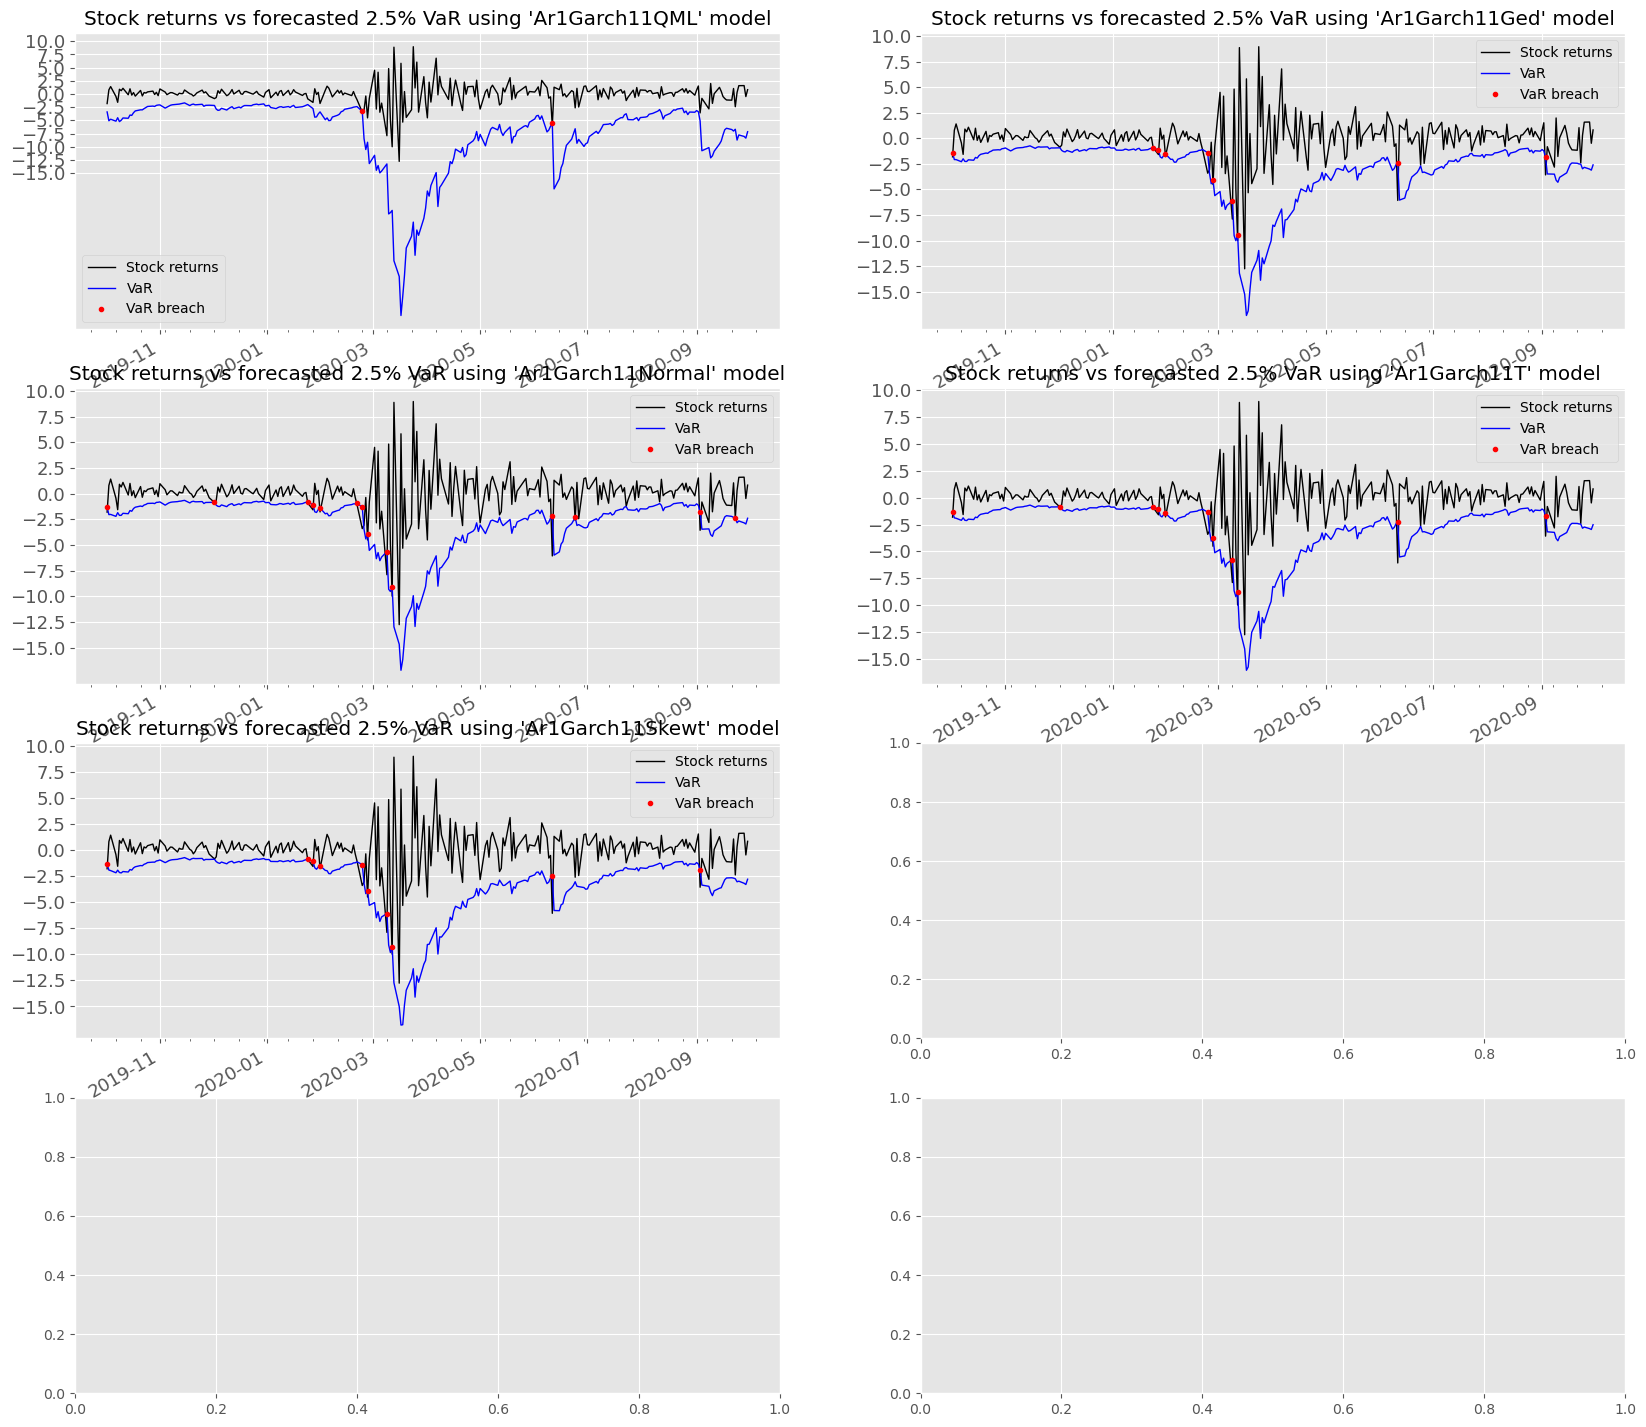

In [52]:
models_list = list(models)

mpl.rcParams["figure.dpi"] = 100
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(20, 20))
for i, ax in zip(range(0,7), axes.flat):
    name = models_list[i] + "_25"
    viz25_df["rr"].plot(color='black', linewidth=1, ax=ax)
    viz25_df[name].plot(color='blue', linewidth=1, ax=ax)
    ax.plot(viz25_df[name][viz25_df["rr"] < viz25_df[name]], color='red', linewidth=0, marker='.')
    ax.set_xlabel("")
    name_plot = "Stock returns vs forecasted 2.5% VaR using '" + name.split("_")[0] + "' model"
    ax.set_title(name_plot)
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.set_yticks(np.arange(-15,12.5, 2.5))
    ax.legend(["Stock returns","VaR","VaR breach"])
    
fig.tight_layout()
fig.delaxes(axes[3][1])
plt.show()

## The absolute number and the percentage of exceedances of the VaR level 

In [13]:
output_ex = list()

for i in models:
    for j in alphas:
        name = i + "_" + j
        ex = sum(results[name] > results["rr"])
        j = "2.5" if j == "25" else "1"
        output_ex.append([i,j,ex])

output_ex = pd.DataFrame(output_ex, columns = ["model","pval","exceed"])
output_cross_tab_ex_absolute = pd.pivot_table(output_ex, index = ['model'], columns=['pval'], values=['exceed'])
output_cross_tab_ex_percent = pd.pivot_table(output_ex, index = ['model'], columns=['pval'], values=['exceed'], margins=False, aggfunc='sum')/252*100

In [14]:
display(output_cross_tab_ex_absolute)
display(output_cross_tab_ex_percent)

exceed    
pval                   1 2.5
model                       
genextreme             9  13
hs                    12  17
laplace               18  28
laplaceasymmetric     17  24
norm                  16  24
skewnorm              15  21
t                     13  23

exceed           
pval                      1        2.5
model                                 
genextreme         3.571429   5.158730
hs                 4.761905   6.746032
laplace            7.142857  11.111111
laplaceasymmetric  6.746032   9.523810
norm               6.349206   9.523810
skewnorm           5.952381   8.333333
t                  5.158730   9.126984

##  Kupiec test (unconditional coverage), Christoffersen test (conditional coverage) and Engle test (dynamic quantile)

In [15]:
output_test = list()

for i in models:
    for j in alphas:
        name = i + "_" + j
        realisation_array = results["rr"].values
        vars_array = results[name].values
        j = "2.5" if j == "25" else "1"
        p = 0.025 if j == "25" else 0.01
        test1 = kupiec_pof(y = pd.DataFrame(realisation_array), y_p = pd.DataFrame(vars_array), p = p)["p-value"]
        test2 = haas_dweibull(y = pd.DataFrame(realisation_array), y_p = pd.DataFrame(vars_array), p = p)["p-value"]
        test3 = christoffersen_ccov(y = pd.DataFrame(realisation_array), y_p = pd.DataFrame(vars_array), p = p)["p-value"]
        test4 = engle_dq (y = pd.DataFrame(realisation_array), y_p = pd.DataFrame(vars_array), p = p, k = 3)["p-value"]
        output_test.append([i,j,test1, test2, test3, test4])

output_test = pd.DataFrame(output_test, columns = ["model","pval","kupiec_pof","haas_dweibull","christoffersen_ccov","engle_dq"])
output_cross_tab_test = pd.pivot_table(output_test, index = ['model'], columns=['pval'], values=['kupiec_pof','haas_dweibull','christoffersen_ccov','engle_dq']).round(3)

In [16]:
output_cross_tab_test

christoffersen_ccov      engle_dq      haas_dweibull         \
pval                                1  2.5        1  2.5             1    2.5   
model                                                                           
genextreme                        0.0  0.0      0.0  0.0         0.655  0.222   
hs                                0.0  0.0      0.0  0.0         0.268  0.045   
laplace                           0.0  0.0      0.0  0.0         0.018  0.000   
laplaceasymmetric                 0.0  0.0      0.0  0.0         0.045  0.000   
norm                              0.0  0.0      0.0  0.0         0.119  0.000   
skewnorm                          0.0  0.0      0.0  0.0         0.114  0.001   
t                                 0.0  0.0      0.0  0.0         0.222  0.000   

                  kupiec_pof       
pval                       1  2.5  
model                              
genextreme             0.001  0.0  
hs                     0.000  0.0  
laplace                0.000  0.0  
laplaceasymmetric      0.000  0.0  
norm                   0.000  0.0  
skewnorm               0.000  0.0  
t                      0.000  0.0

## Financial provisions

In [17]:
amount = 1e4 #USD
output_prov = list()

for i in models:
    for j in alphas:
        name = i + "_" + j
        prov = sum(abs(results[name].values) * amount)
        j = "2.5" if j == "25" else "1"
        output_prov.append([i,j,prov])

output_prov = pd.DataFrame(output_prov, columns = ["model","pval","prov"])
output_cross_prov = pd.pivot_table(output_prov, index = ['model'], columns=['pval'], values=['prov'])

In [18]:
output_cross_prov

prov              
pval                          1           2.5
model                                        
genextreme         1.079905e+07  8.977319e+06
hs                 9.129988e+06  6.515477e+06
laplace            6.388629e+06  4.846139e+06
laplaceasymmetric  6.744553e+06  5.122759e+06
norm               6.564211e+06  5.515799e+06
skewnorm           6.949245e+06  5.759966e+06
t                  8.895716e+06  5.246073e+06